In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
from tqdm import trange
import blimpy as bl
%matplotlib inline

bshuf filter already loaded, skip it.
zfp filter already loaded, skip it.


First we will read in the data that I processed on GCP

For simplicity, I will start with the L-band files from turboSETI, and then make a function so that I can repeat the process on other bands as well as the energy detection data

In [3]:
dir_path = "/home/danielb/fall_2021/spectral_occupancy/"
ts = dir_path + "turbo-seti/"
ed = dir_path + "energy-detection/"
fine = ed + "fine_channel_fraction/"

In [4]:
ts_pickles = glob.glob(ts+"*pkl")
ed_pickles = glob.glob(ed+"*pkl")

In [5]:
def read_pickle(pickle_path):
    with open(pickle_path, "rb") as f:
        contents = pickle.load(f)
    return contents

In [6]:
l_band = read_pickle(ts_pickles[2])

In [7]:
def sample_spectrum(spectral_occupancy):
    return np.random.random(size=len(spectral_occupancy))

def simulate_cadence(spectral_occupancy):
    on_target = np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    off_target= np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    for i in range(3):
        on_target[i,:] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    for i in range(3):
        off_target[i, :] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    return on_target, off_target

def signal_search(spectral_occupancy):
    """
    currently set to filter level 3:
    events that are present in *ALL* ons
    and found in *NO* offs 
    """
    on, off = simulate_cadence(spectral_occupancy)
    # signals should be present in all ons
    all_on = np.sum(on, axis=0) == 3
    
    # signals should be absent in all offs
    no_off = np.sum(off, axis=0) == 0
    
    #check that hits are present in "ons" and absent in "offs"
    hit_detection = (all_on & no_off)
    
    return hit_detection

def search_n_times(spectral_occupancy, N_iterations=10000):
    search_results = np.empty(shape=(N_iterations, len(spectral_occupancy)))
    
    for i in trange(N_iterations):
        search_results[i,:] = signal_search(spectral_occupancy)
    
    return search_results

In [8]:
results = search_n_times(l_band["bin_heights"])
event_counts = np.sum(results, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10394.36it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3355.15it/s]


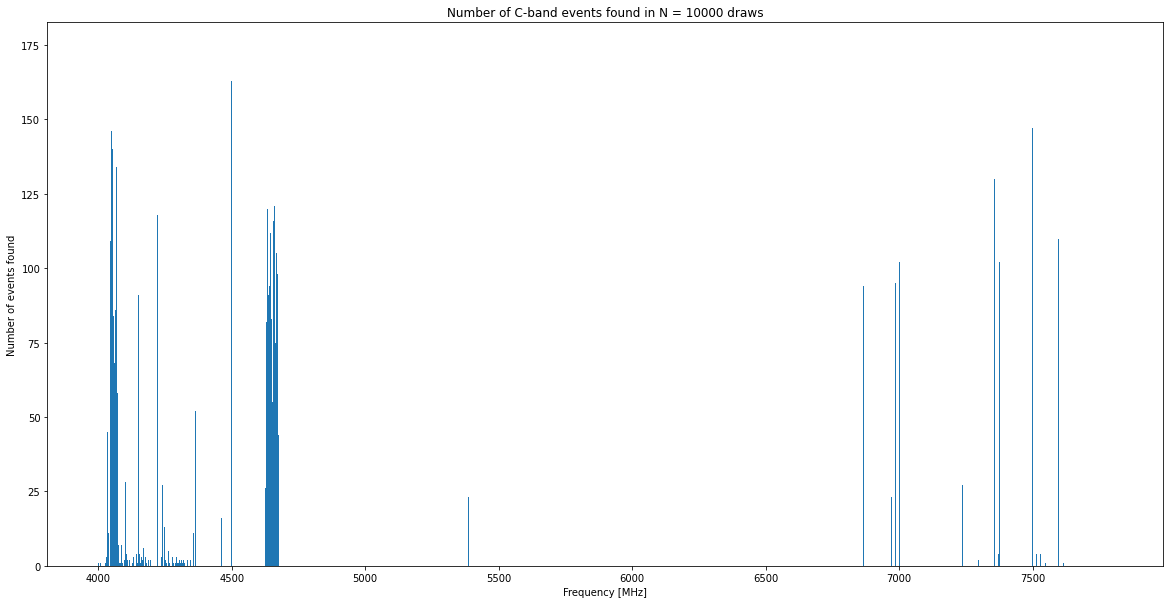

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9391.64it/s]


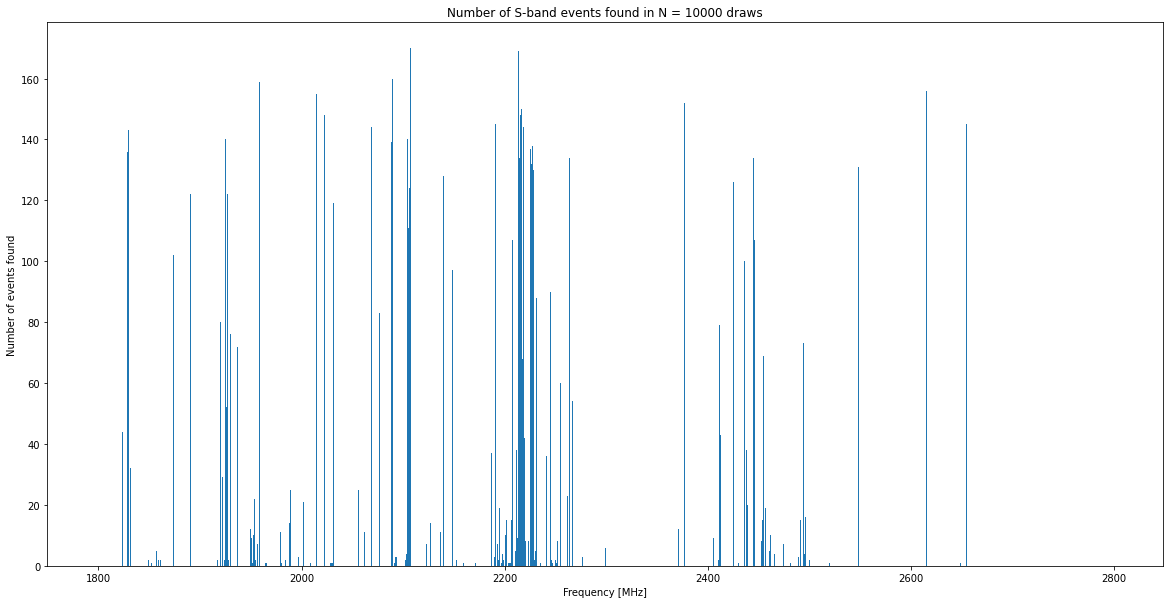

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10893.33it/s]


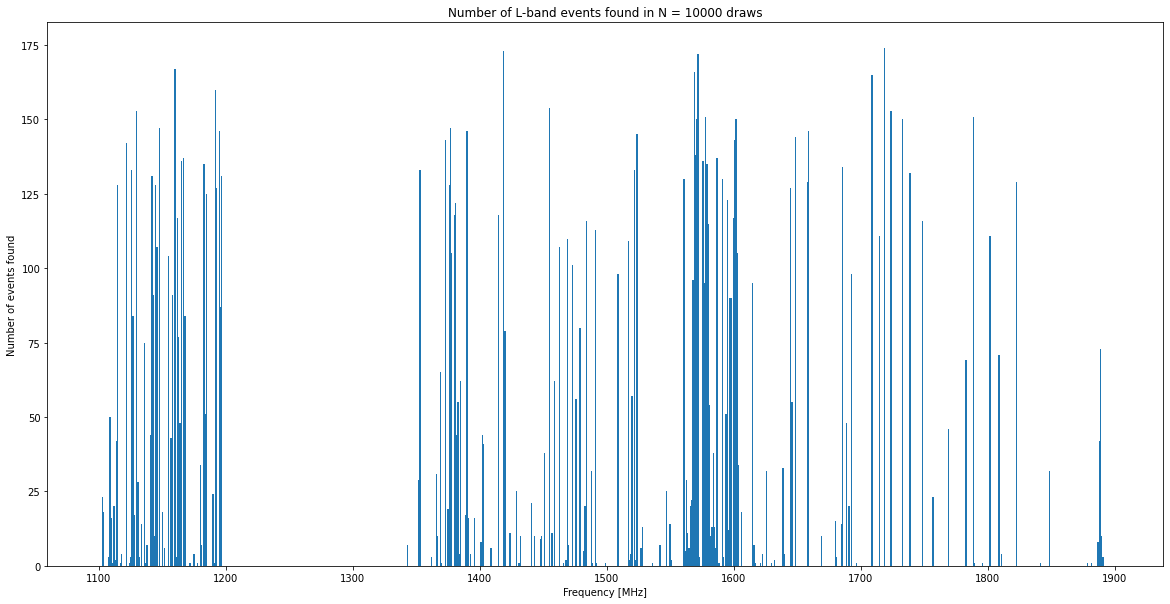

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3765.40it/s]


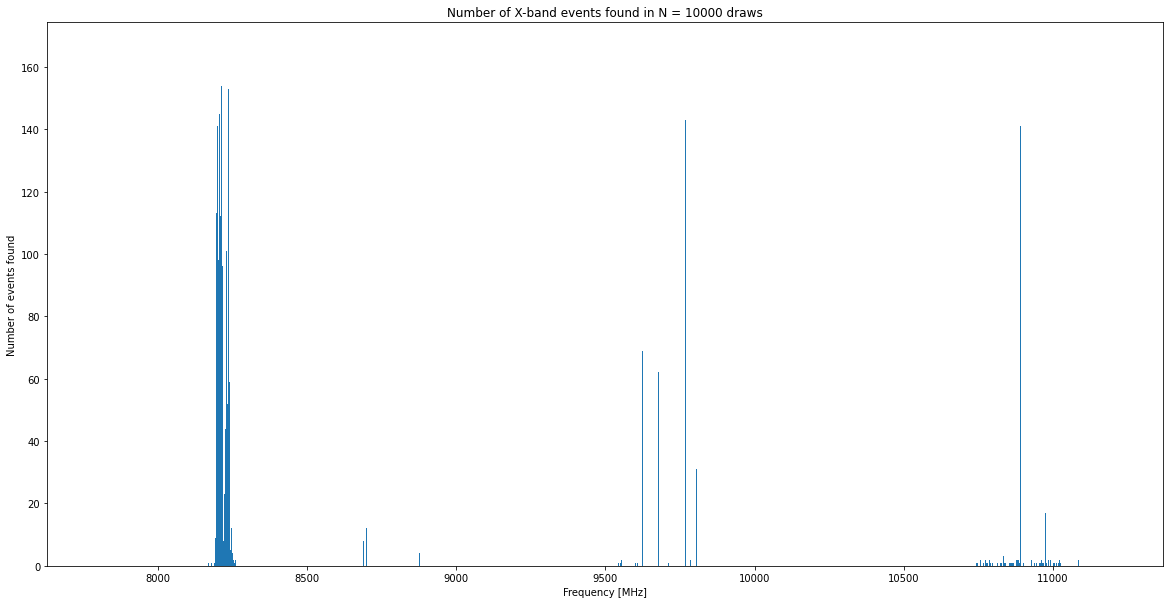

In [9]:
for i in range(4):
    data = ts_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# repeating the process with energy detection data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3360.17it/s]


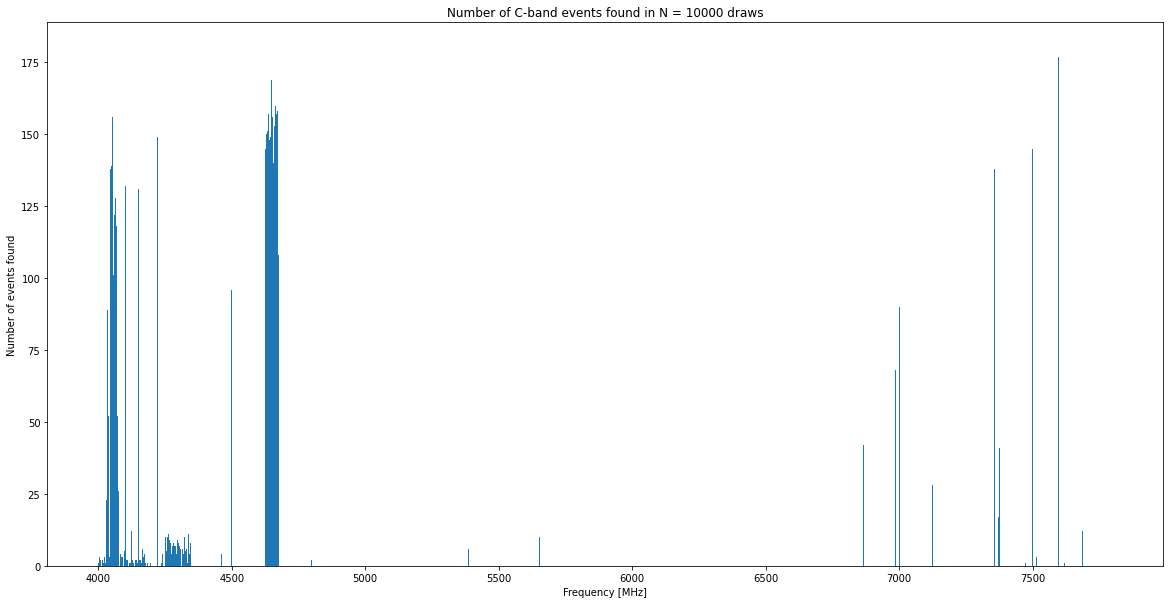

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10931.00it/s]


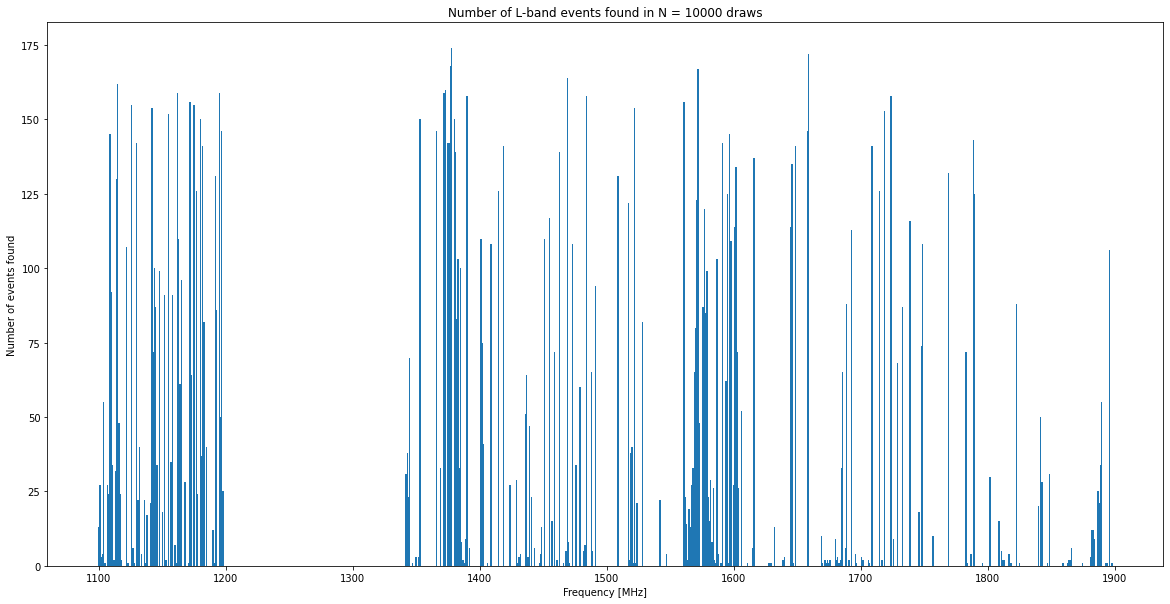

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9107.06it/s]


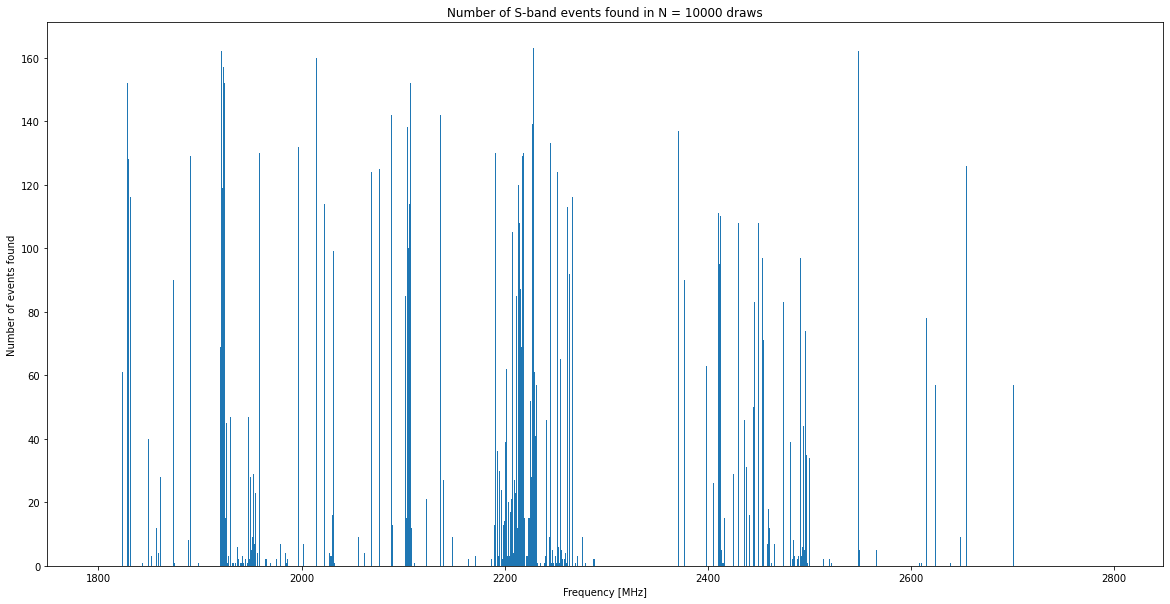

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3712.64it/s]


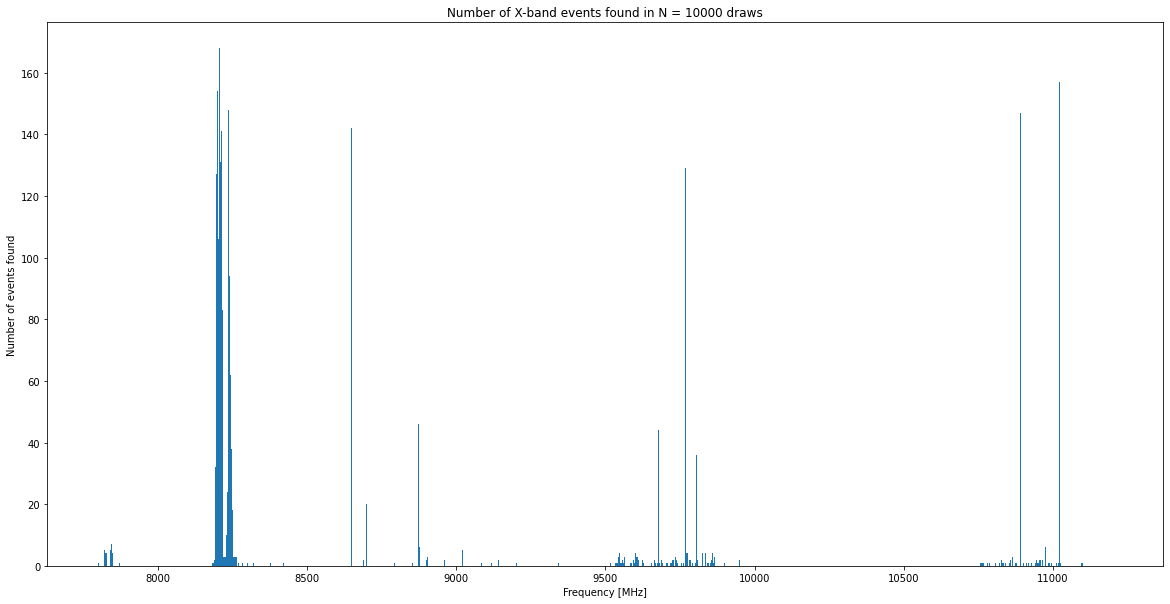

In [10]:
for i in range(4):
    data = ed_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# Ratio of bin height vs frequency comparing energy detection and turboSETI

In [11]:
ed_data = read_pickle(ed_pickles[1])
ts_data = read_pickle(ts_pickles[2])

/tmp/ipykernel_9259/2297618612.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_9259/2297618612.py:1: RuntimeWarning: invalid value encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_9259/2297618612.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]
/tmp/ipykernel_9259/2297618612.py:2: RuntimeWarning: invalid value encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]


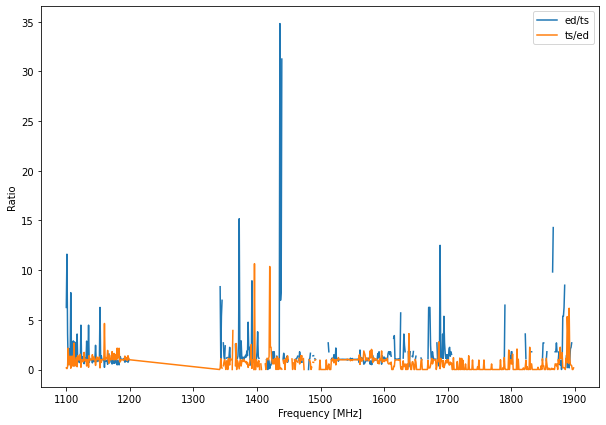

In [12]:
ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]

plt.figure(figsize=(10,7))
plt.plot(ts_data["bin_edges"][:-1], ed_over_ts, label="ed/ts")
plt.plot(ts_data["bin_edges"][:-1], ts_over_ed, label="ts/ed")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
# plt.yscale("log")
plt.show()

# Fraction of fine channels that detect a signal 

In [13]:
fine_pickles = glob.glob(fine+"*")
fine_pickles.sort()

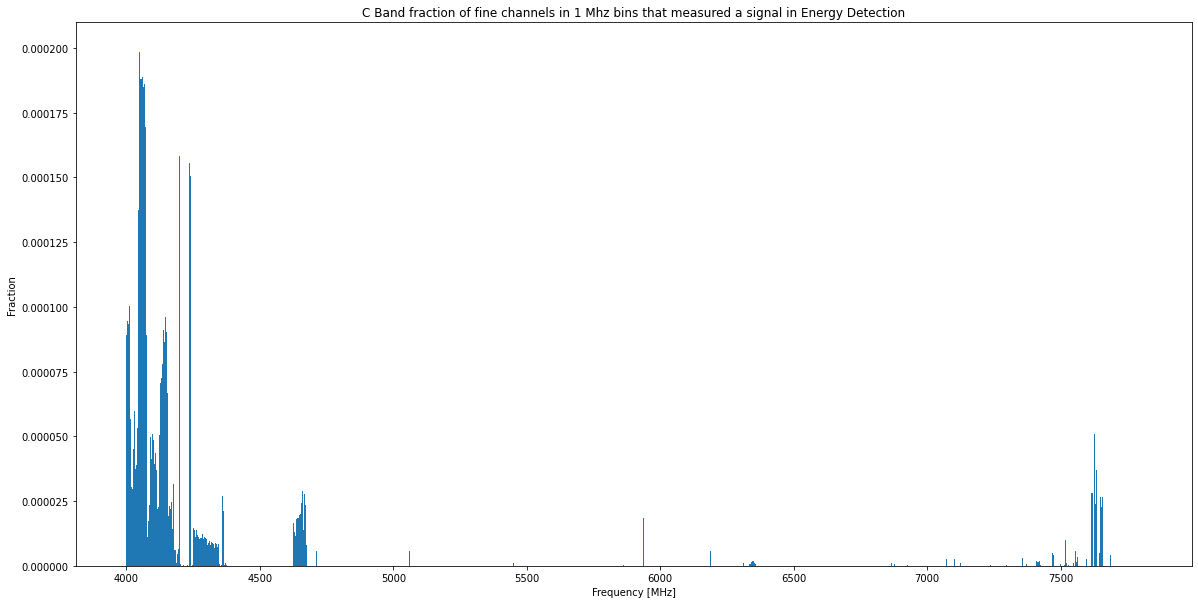

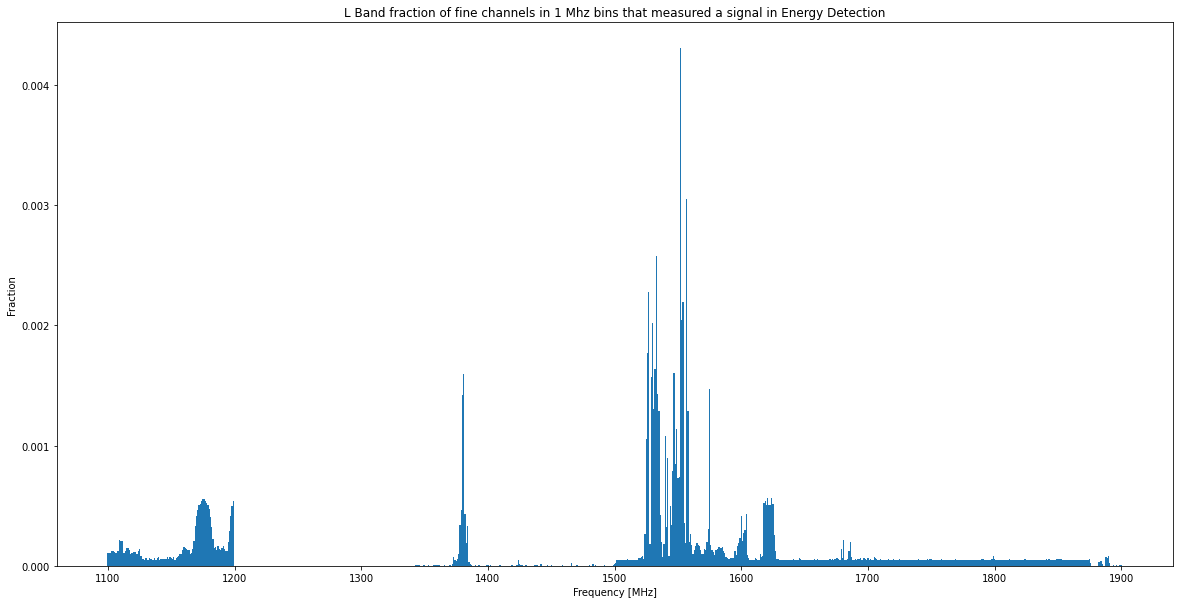

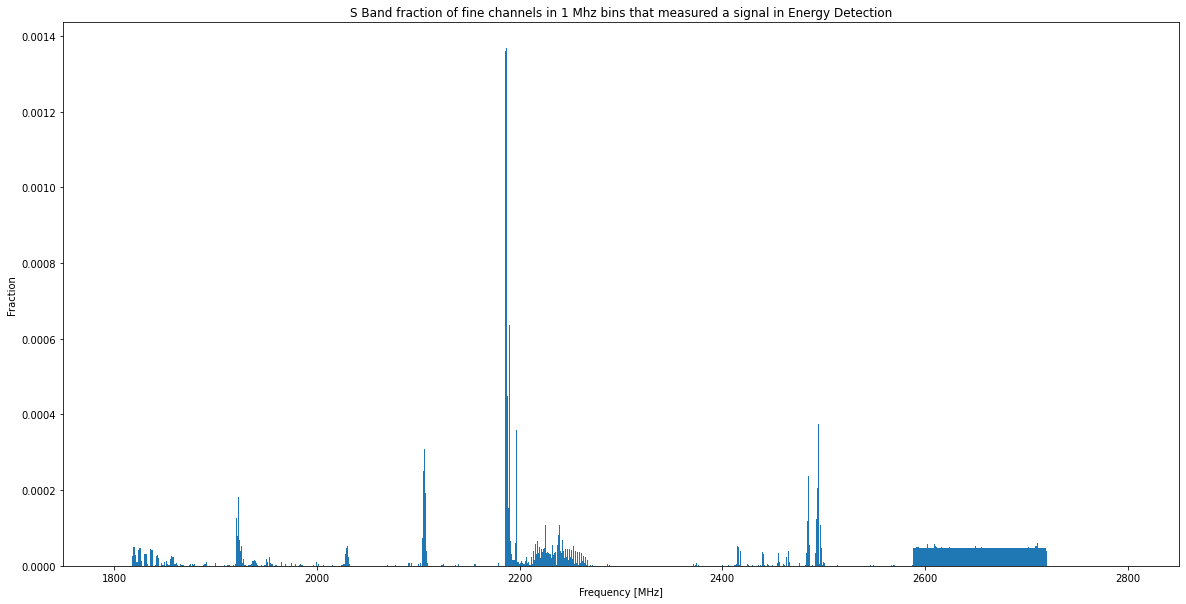

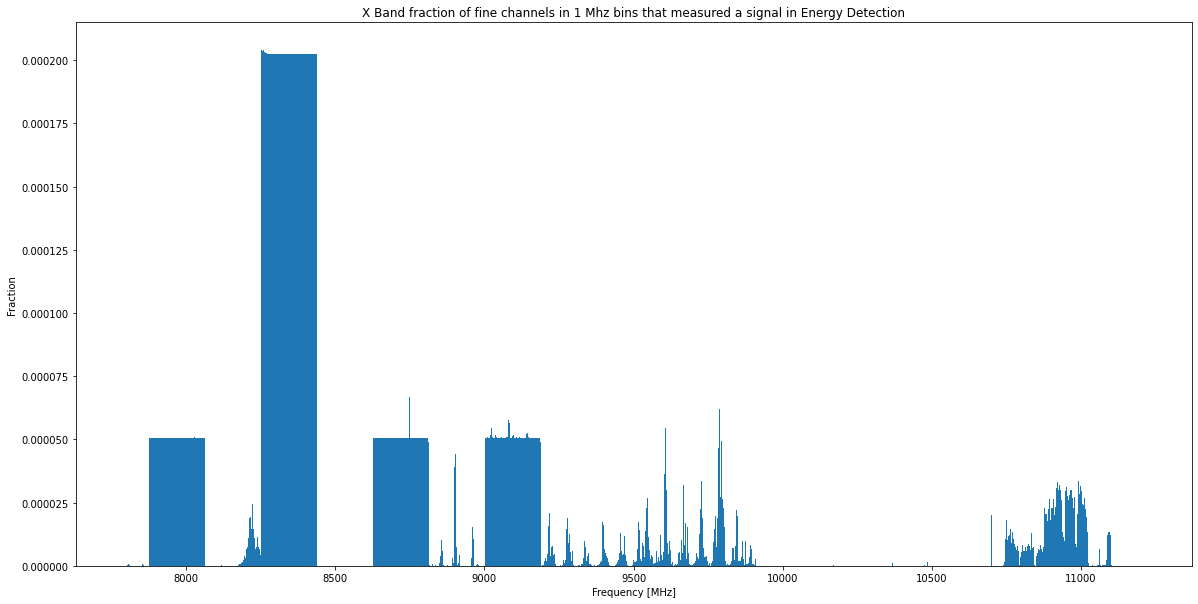

In [14]:
for i in range(4):
    fraction_data = read_pickle(fine_pickles[i])
    fractions = fraction_data["fine channel fraction"]
    frequencies = fraction_data["frequency bin"]
    band = fraction_data["band"]
    savepath = "/home/danielb/fall_2021/fine_channel_plots/%s_band_energy_detection_fine_channel_fraction.pdf"%band
    
    plt.figure(figsize=(20,10))
    plt.bar(frequencies, fractions, width=1)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Fraction")
    plt.title("%s Band fraction of fine channels in %s Mhz bins that measured a signal in Energy Detection"%(fraction_data["band"], fraction_data["bin_width"]))
    plt.savefig(savepath, bbox_inches='tight', transparent=False)

### Interesting details

X band has intervals with a much higher fraction than the surrounding

L band has an interval of constant fraction in frequencies between ~1650-1900 MHz



## Identifying strange files

In [18]:
xband = read_pickle(fine_pickles[3])
xband.keys()

dict_keys(['fine channel fraction', 'frequency bin', 'dataframe', 'bin_width', 'fine_channel_width', 'band', 'threshold', 'algorithm', 'n files'])

In [19]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_column", 10)

In [23]:
df = xband["dataframe"].T

In [24]:
df

,7800.0,7801.0,7802.0,7803.0,7804.0,...,11196.0,11197.0,11198.0,11199.0,11200.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14835_HIP94609_0038,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14512_TIC284450803_0037,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79017_TIC266500992_0031,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_21195_TIC349827430_0053,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79336_HIP18962_0032,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
spliced_blc00010203040506o7o0111213141516o021222324252627_guppi_58806_42870_HIP75370_0126,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58808_60850_TIC232967666_0050,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc10111213141516o7o0212223242526o7o031323334353637_guppi_58868_40320_TIC281731203_0019,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_08997_TIC372757221_0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [25]:
colnames = np.arange(7850, 8100, dtype=float)
keep = []
for label in colnames:
    keep.append(label)
temp = np.mean(df[colnames], axis=0)

<BarContainer object of 250 artists>

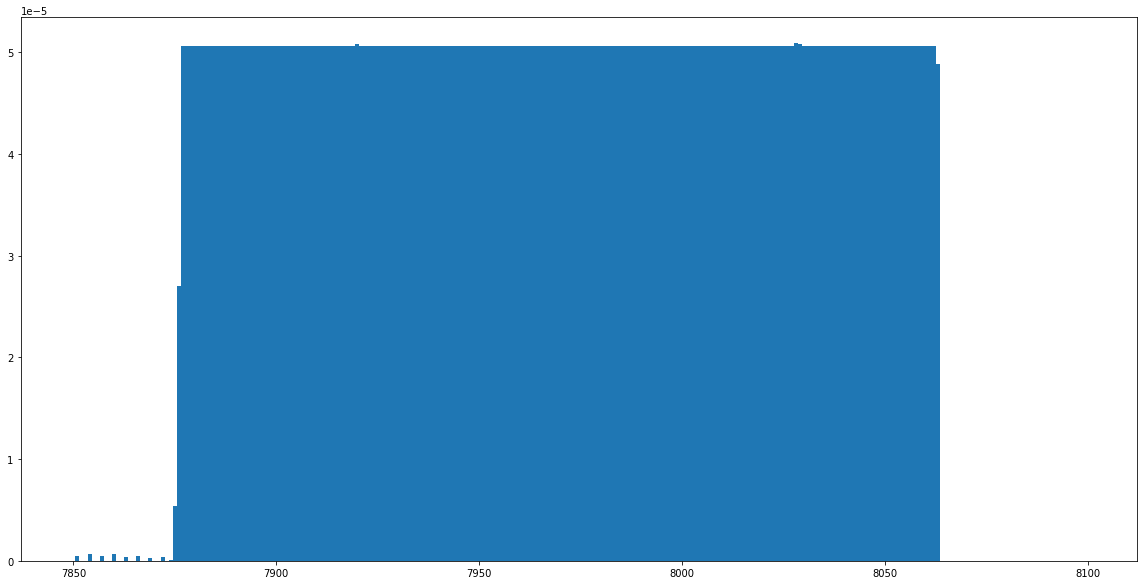

In [26]:
plt.figure(figsize=(20,10))
plt.bar(colnames, temp, 1)

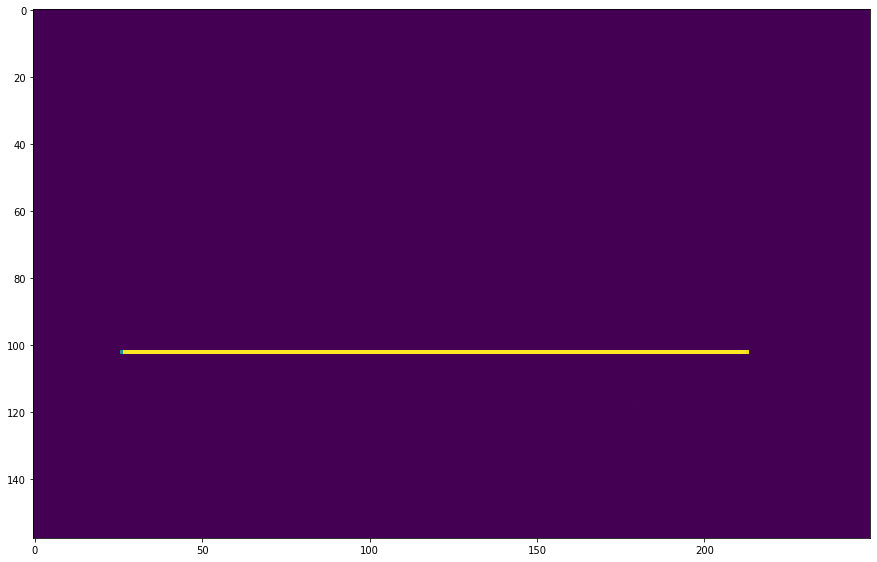

In [27]:
arr = np.array(df[colnames])

plt.figure(figsize=(15,15))
plt.imshow(arr)

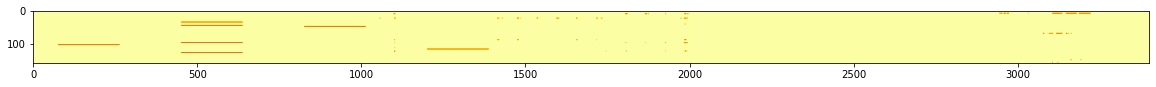

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(np.array(df)>1e-3, cmap="inferno_r")
# plt.colorbar()

In [29]:
def z_score(df):
    arr = np.array(df)
    mean = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    no_data = np.where(np.sum(arr, axis=0) == 0)
    # correct for zero standard deviations
    sd[no_data] = np.inf
    mask = np.where(sd==0)
    sd[mask] = 1e-9
    z_tbl = (arr - mean)/sd
    return z_tbl

In [30]:
np.min(z_score(df)), np.max(z_score(df))

(-12.529964086141744, 12.529964086141767)

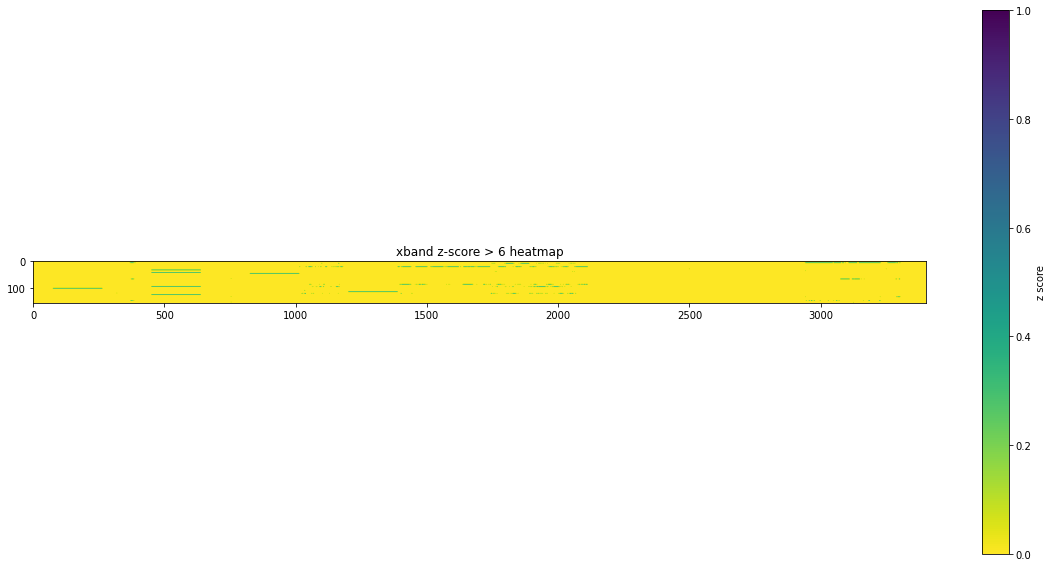

In [114]:
z_val = 6

plt.figure(figsize=(20,10))
plt.imshow(np.abs(z_score(df))>z_val, cmap="viridis_r")
plt.colorbar(label="z score")
plt.title("xband z-score > %s heatmap"%z_val)
plt.savefig("xband_heatmap.pdf")

In [32]:
def identify_bad_files(df, min_z):
    z_tbl = z_score(df)
    bad_mask = np.where(np.abs(z_tbl) > min_z)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

def high_mean(df, min_mean):
    arr = np.array(df)
    bad_mask = np.where(arr > min_mean)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

In [116]:
z_tbl = z_score(df)

In [99]:
freqs = np.arange(1500,2000) + 7800
temp = df[freqs]
a = high_mean(temp, 1e-3)
a

Index(['spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_13018_TIC359496368_0032',
       'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_11079_TIC320525204_0026',
       'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_11760_TIC154872375_0024',
       'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_11399_HIP86058_0027',
       'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_13341_HIP90580_0033',
       'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_12700_HIP90818_0031'],
      dtype='object')

In [89]:
df.iloc[0].name

'spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14835_HIP94609_0038'

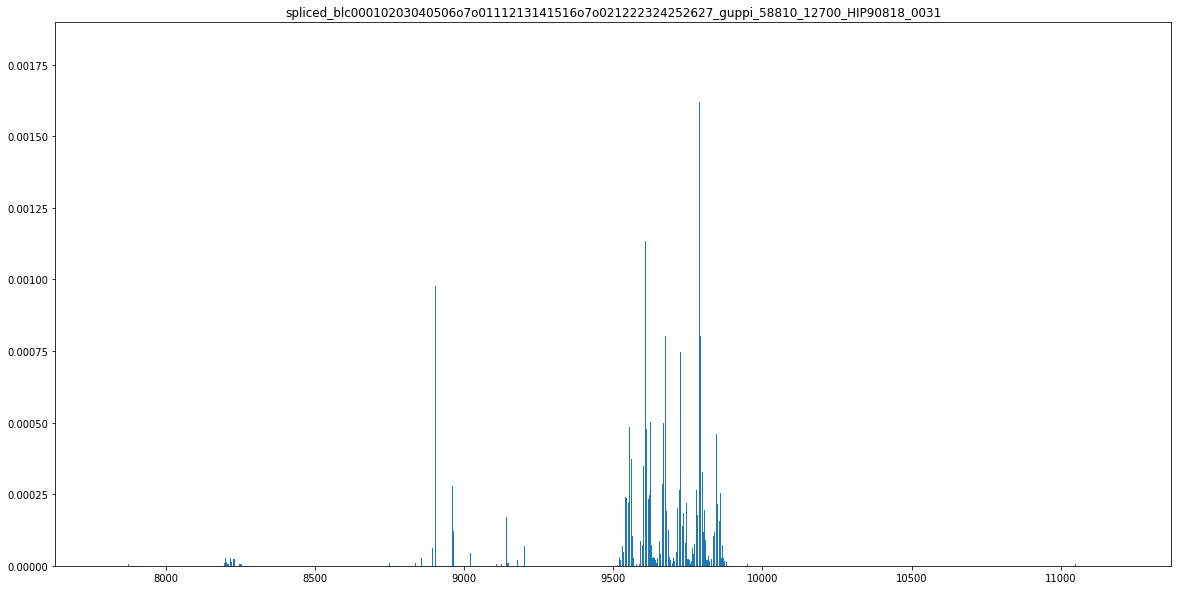

In [108]:
savepath = "/home/danielb/fall_2021/flagged_plots/z_score_flag/fraction/"

index = 5
lookup = df.T
plt.figure(figsize=(20,10))
plt.bar(df.columns, lookup[a[index]].values)
plt.title(a[index])
plt.savefig(savepath + a[index] + ".pdf", bbox_inches='tight', transparent=False);
# plt.xlim(8600,8850);

## Plotting examples of strange files

blimpy.io.base_reader WARNING  Setting data limit = 7.5 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


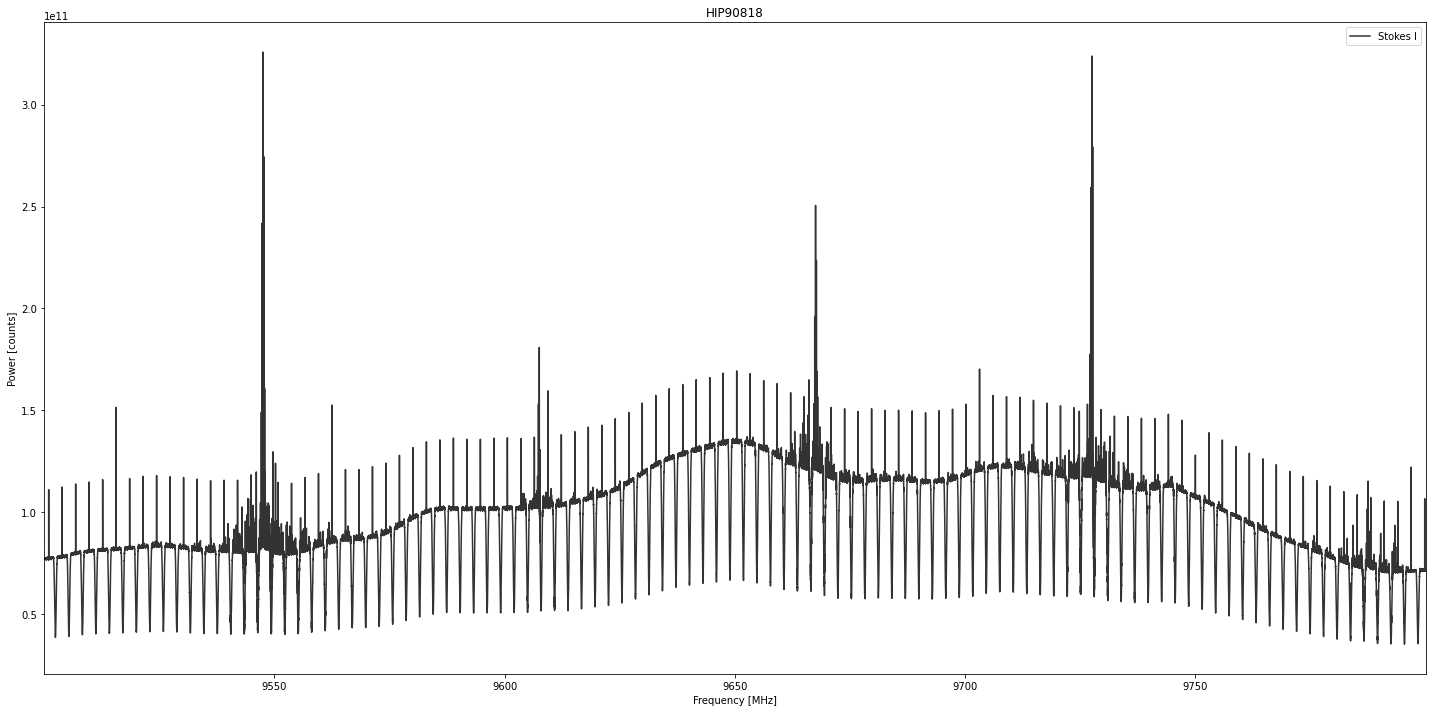

In [109]:
dir_path = "/home/gcsfuse/blpc0/bl_tess/x_band/"
h5_path = glob.glob(dir_path + a[index] + "*0.h5")[0]
f_start = 9500
f_stop = 9800

save_dir = "/home/danielb/fall_2021/flagged_plots/z_score_flag/spectrum/"
save_path = save_dir + a[index] + "_%s_to_%s.pdf"%(f_start, f_stop)

hf = bl.Waterfall(h5_path, f_start=f_start, f_stop=f_stop, max_load=7.5)
print("data loaded")
plt.figure(figsize=(20,10))
hf.plot_spectrum()
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight', transparent=False)
del hf